In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas_datareader.data as web

In [2]:
apple = web.DataReader('aapl'
                       , 'yahoo'
                       , start = '12/12/1980'
                      )
apple.shape

(10091, 6)

In [3]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615


In [4]:
apple['Close_Shift1_DOwn'] = apple.Close.shift(1, fill_value = 0.0)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn
Date,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513


In [5]:
# Function to find the max daily change in the direction of overall daily change 
def hl(h, l, o, c):
    if o - c > 0:
        return l-h
    else:
        return h-l

In [6]:
# Max daily change in the same direction fo daily change
apple['Max Daily Change'] = apple.apply(lambda x: hl(x[0], x[1], x[2], x[3]), axis=1)
apple.sample(10)

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change
Date,,,,,,,,
2006-03-23,2.210714,2.128929,2.207857,2.148571,1.427826e+09,1.853467,2.202500,-0.081786
1999-10-05,0.608259,0.578125,0.585938,0.606585,8.142064e+08,0.523271,0.576451,0.030134
1986-07-07,0.168527,0.157924,0.167969,0.159040,1.818208e+08,0.125260,0.167969,-0.010603
2010-05-27,9.067500,8.896786,8.950000,9.048214,6.662824e+08,7.805451,8.718214,0.170714
1995-05-04,0.356027,0.339286,0.341518,0.343750,3.036432e+08,0.293998,0.340402,0.016741
1984-02-03,0.113839,0.109375,0.111049,0.109375,1.454880e+08,0.086143,0.111049,-0.004464
2003-03-03,0.270714,0.259821,0.268036,0.261607,2.037616e+08,0.225676,0.268036,-0.010893
1981-11-18,0.084821,0.084263,0.084263,0.084263,2.914240e+07,0.066366,0.081473,0.000558
2004-10-25,0.854286,0.840536,0.842857,0.849107,3.926440e+08,0.732483,0.846607,0.013750


In [7]:
# negative means the next day opened lower than the pervious day
apple['Interday Change'] = apple.apply(lambda x: x[2] - x[6], axis = 1)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change
Date,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348


In [8]:
# Positive 'Close Adjusted Close' means overvalued price at close of day
apple['Close Adjusted Close'] = apple.apply(lambda x: x[3] - x[5], axis = 1)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247


In [9]:
apple[(apple['Max Daily Change'] > 0) & (apple['Interday Change'] < 0)]

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1986-03-17,0.116071,0.113281,0.116071,0.116071,118720000.0,0.091418,0.116629,0.002790,-0.000558,0.024654
1986-08-01,0.141741,0.138951,0.138951,0.140067,150080000.0,0.110316,0.139509,0.002790,-0.000558,0.029751
1986-08-12,0.153460,0.148996,0.148996,0.152902,244160000.0,0.120425,0.149554,0.004464,-0.000558,0.032477
1986-08-19,0.158482,0.154576,0.156808,0.157924,137782400.0,0.124381,0.157924,0.003906,-0.001116,0.033544
1986-08-20,0.162946,0.157366,0.157366,0.161830,171315200.0,0.127457,0.157924,0.005580,-0.000558,0.034373
...,...,...,...,...,...,...,...,...,...,...
2020-11-16,120.989998,118.150002,118.919998,120.300003,91183000.0,120.300003,119.260002,2.839996,-0.340004,0.000000
2020-11-19,119.059998,116.809998,117.589996,118.639999,74113000.0,118.639999,118.029999,2.250000,-0.440002,0.000000
2020-12-02,123.370003,120.889999,122.019997,123.080002,89004200.0,123.080002,122.720001,2.480003,-0.700005,0.000000


In [10]:
apple[apple['Open'] == apple['Close']]

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close
Date,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247
1980-12-19,0.126674,0.126116,0.126116,0.126116,48630400.0,0.099329,0.118862,0.000558,0.007254,0.026787
1980-12-22,0.132812,0.132254,0.132254,0.132254,37363200.0,0.104163,0.126116,0.000558,0.006138,0.028091
...,...,...,...,...,...,...,...,...,...,...
2014-07-01,23.517500,23.282499,23.379999,23.379999,152892000.0,21.101110,23.232500,0.235001,0.147499,2.278889
2015-07-28,30.977501,30.637501,30.844999,30.844999,134472400.0,28.326986,30.692499,0.340000,0.152500,2.518013
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.944889,43.750000,0.420002,-0.162498,1.642612


In [11]:
apple['Open Close % Change'] = (apple['Close'] - apple['Open']) / apple['Open'] * 100
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change
Date,,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262,0.000000
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839,-0.456625
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943,-0.492609
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535,0.000000
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247,0.000000


In [12]:
apple['Open Close % Change'].describe()

count    10091.000000
mean        -0.010760
std          2.343740
min        -24.352329
25%         -1.162786
50%          0.000000
75%          1.087892
max         19.266055
Name: Open Close % Change, dtype: float64

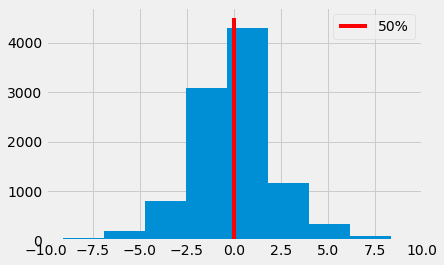

In [13]:
apple['Open Close % Change'].hist(bins=20)
plt.vlines(0, 0, 4500, colors='r', label = '50%')
plt.xlim(-10, 10)
plt.legend();

In [14]:
apple['Open Close % Change'].quantile([0.84])

0.84    1.83602
Name: Open Close % Change, dtype: float64

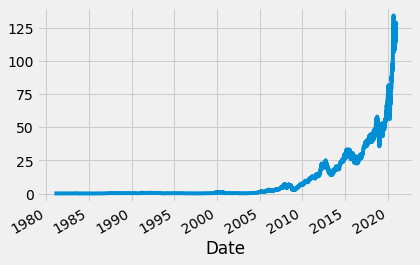

In [15]:
apple['Close'].plot();

In [16]:
def decision(p):
    if p > 1.5:
        return 1
    elif p < -0.75:
        return -1
    else:
        return 0

In [17]:
apple['Buy Hold Sell'] = apple.apply(lambda x: decision(x[10]), axis = 1)

In [18]:
apple.sample(10)

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change,Buy Hold Sell
Date,,,,,,,,,,,,
2001-07-20,0.358214,0.348036,0.351786,0.356786,444584000.0,0.307782,0.356429,0.010179,-0.004643,0.049004,1.421318,0
1993-04-06,0.448661,0.435268,0.446429,0.435268,168369600.0,0.362434,0.446429,-0.013393,0.000000,0.072834,-2.499997,-1
1998-11-03,0.341518,0.333147,0.333705,0.337612,370451200.0,0.291241,0.335938,0.008371,-0.002232,0.046371,1.170569,0
1989-09-06,0.400670,0.392857,0.399554,0.399554,86755200.0,0.321273,0.399554,0.007812,0.000000,0.078281,0.000000,0
2003-12-02,0.391071,0.382321,0.385714,0.384643,205296000.0,0.331813,0.387679,-0.008750,-0.001964,0.052830,-0.277776,0
1987-06-15,0.354911,0.345982,0.352679,0.350446,259840000.0,0.276434,0.352679,-0.008929,0.000000,0.074013,-0.632909,0
2013-11-21,18.614643,18.345358,18.485714,18.612143,262026800.0,16.605282,18.392857,0.269285,0.092857,2.006861,0.683926,0
1988-08-25,0.361607,0.350446,0.359375,0.358259,127680000.0,0.285227,0.363839,-0.011161,-0.004464,0.073032,-0.310558,0
1993-07-23,0.245536,0.232143,0.241071,0.234375,233777600.0,0.195564,0.236607,-0.013393,0.004464,0.038811,-2.777779,-1


In [19]:
apple['Buy Hold Sell Shift1 Down'] = apple['Buy Hold Sell'].shift(1, fill_value=0).astype(int)
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Close_Shift1_DOwn,Max Daily Change,Interday Change,Close Adjusted Close,Open Close % Change,Buy Hold Sell,Buy Hold Sell Shift1 Down
Date,,,,,,,,,,,,,
1980-12-12,0.128906,0.128348,0.128348,0.128348,469033600.0,0.101087,0.000000,0.000558,0.128348,0.027262,0.000000,0,0
1980-12-15,0.122210,0.121652,0.122210,0.121652,175884800.0,0.095813,0.128348,-0.000558,-0.006138,0.025839,-0.456625,0,0
1980-12-16,0.113281,0.112723,0.113281,0.112723,105728000.0,0.088780,0.121652,-0.000558,-0.008371,0.023943,-0.492609,0,0
1980-12-17,0.116071,0.115513,0.115513,0.115513,86441600.0,0.090978,0.112723,0.000558,0.002790,0.024535,0.000000,0,0
1980-12-18,0.119420,0.118862,0.118862,0.118862,73449600.0,0.093615,0.115513,0.000558,0.003348,0.025247,0.000000,0,0


In [20]:
# Select features
apple.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Close_Shift1_DOwn', 'Max Daily Change', 'Interday Change',
       'Close Adjusted Close', 'Open Close % Change', 'Buy Hold Sell',
       'Buy Hold Sell Shift1 Down'],
      dtype='object')

In [21]:
X = apple[['Volume'
           , 'Max Daily Change'
           , 'Interday Change'
           , 'Close Adjusted Close'
           , 'Buy Hold Sell Shift1 Down'
          ]
         ]

In [22]:
X.head()

,Volume,Max Daily Change,Interday Change,Close Adjusted Close,Buy Hold Sell Shift1 Down
Date,,,,,
1980-12-12,469033600.0,0.000558,0.128348,0.027262,0
1980-12-15,175884800.0,-0.000558,-0.006138,0.025839,0
1980-12-16,105728000.0,-0.000558,-0.008371,0.023943,0
1980-12-17,86441600.0,0.000558,0.002790,0.024535,0
1980-12-18,73449600.0,0.000558,0.003348,0.025247,0


In [23]:
X['Buy Hold Sell Shift1 Down'].value_counts()

 0    4887
-1    3264
 1    1940
Name: Buy Hold Sell Shift1 Down, dtype: int64